## Libraries

Do not import any additional libraries

In [ ]:
%matplotlib inline
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn.functional as F

## Download dataset and create a data loader
PyTorch has two [primitives to work with data](https://pytorch.org/docs/stable/data.html):
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.

PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html),
all of which include datasets. For this assignment, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO, MNIST ([full list here](https://pytorch.org/vision/stable/datasets.html)). In this tutorial, we
use the CIFAR10 dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

#download training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

#download test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Creating Models
To define a neural network in PyTorch, we create a class that inherits
from [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [ ]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

# conv 5x5 model
# Define a CNN model with following layers: input > Conv > Pool > Conv > Pool > Linear > Output
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5, padding='same')
        self.conv2 = nn.Conv2d(16, 32, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model = CNN().to(device)
print(model)

Using cuda device
CNN(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


In [ ]:
# conv 3x3 model
# Define a CNN model with following layers: input > Conv > Conv > Pool > Conv > Conv > Pool > Linear > Output
class CNN2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding='same')
        self.conv2 = nn.Conv2d(16, 16, 3, padding='same')
        self.conv3 = nn.Conv2d(16, 32, 3, padding='same')
        self.conv4 = nn.Conv2d(32, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*8*8,512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)

        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x), 1)
        return x

model2 = CNN2().to(device)
print(model2)

CNN2(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)


## Optimizing the Model Parameters
To train a model, we need a [loss function](https://pytorch.org/docs/stable/nn.html#loss-functions)
and an [optimizer](https://pytorch.org/docs/stable/optim.html).



In [ ]:
#negative log likelihood loss
loss_fn = nn.NLLLoss()

#Adam optimizer
optimizer = torch.optim.Adam(model.parameters())
optimizer2 = torch.optim.Adam(model2.parameters())


## Training function

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

## Testing function

We also check the model's performance against the test dataset to ensure it is learning.



In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

## Training process

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [ ]:
# conv 5x5 model
epochs = 10
all_train_accuracies = []
all_test_accuracies = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model, loss_fn, optimizer)
    all_train_accuracies += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model, loss_fn)
    all_test_accuracies += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|█         | 1/10 [00:26<03:54, 26.05s/it]

Epoch 1:	 Train accuracy: 50.4%	 Avg train loss: 1.371782	 Test accuracy: 60.1%	 Avg test loss: 1.122824


 20%|██        | 2/10 [00:42<02:42, 20.33s/it]

Epoch 2:	 Train accuracy: 65.3%	 Avg train loss: 0.975829	 Test accuracy: 67.5%	 Avg test loss: 0.926009


 30%|███       | 3/10 [00:58<02:10, 18.63s/it]

Epoch 3:	 Train accuracy: 72.1%	 Avg train loss: 0.791924	 Test accuracy: 71.0%	 Avg test loss: 0.845399


 40%|████      | 4/10 [01:15<01:47, 17.85s/it]

Epoch 4:	 Train accuracy: 77.2%	 Avg train loss: 0.647397	 Test accuracy: 71.1%	 Avg test loss: 0.837771


 50%|█████     | 5/10 [01:32<01:28, 17.65s/it]

Epoch 5:	 Train accuracy: 82.0%	 Avg train loss: 0.514314	 Test accuracy: 71.6%	 Avg test loss: 0.878775


 60%|██████    | 6/10 [01:49<01:09, 17.43s/it]

Epoch 6:	 Train accuracy: 86.3%	 Avg train loss: 0.389951	 Test accuracy: 72.4%	 Avg test loss: 0.922427


 70%|███████   | 7/10 [02:07<00:52, 17.52s/it]

Epoch 7:	 Train accuracy: 90.6%	 Avg train loss: 0.271263	 Test accuracy: 70.9%	 Avg test loss: 1.080510


 80%|████████  | 8/10 [02:25<00:35, 17.77s/it]

Epoch 8:	 Train accuracy: 93.6%	 Avg train loss: 0.189306	 Test accuracy: 72.0%	 Avg test loss: 1.170242


 90%|█████████ | 9/10 [02:43<00:17, 17.62s/it]

Epoch 9:	 Train accuracy: 95.3%	 Avg train loss: 0.136436	 Test accuracy: 70.2%	 Avg test loss: 1.390801


100%|██████████| 10/10 [02:59<00:00, 17.96s/it]

Epoch 10:	 Train accuracy: 96.4%	 Avg train loss: 0.105487	 Test accuracy: 70.5%	 Avg test loss: 1.451147


In [ ]:
# conv 3x3 model
epochs = 10
all_train_accuracies_2 = []
all_test_accuracies_2 = []
for t in tqdm(range(epochs)):
    
    # train
    train_accuracy, average_train_loss = train(train_dataloader, model2, loss_fn, optimizer2)
    all_train_accuracies_2 += [train_accuracy]
    
    #test
    test_accuracy, average_test_loss = test(test_dataloader, model2, loss_fn)
    all_test_accuracies_2 += [test_accuracy]
    
    print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {average_train_loss:>6f}\t Test accuracy: {100*test_accuracy:0.1f}%\t Avg test loss: {average_test_loss:>6f}")

 10%|█         | 1/10 [00:17<02:36, 17.35s/it]

Epoch 1:	 Train accuracy: 46.8%	 Avg train loss: 1.472022	 Test accuracy: 58.9%	 Avg test loss: 1.161344


 20%|██        | 2/10 [00:35<02:23, 17.95s/it]

Epoch 2:	 Train accuracy: 63.5%	 Avg train loss: 1.027162	 Test accuracy: 66.0%	 Avg test loss: 0.970798


 30%|███       | 3/10 [00:53<02:03, 17.65s/it]

Epoch 3:	 Train accuracy: 70.8%	 Avg train loss: 0.830385	 Test accuracy: 70.0%	 Avg test loss: 0.861790


 40%|████      | 4/10 [01:11<01:47, 17.84s/it]

Epoch 4:	 Train accuracy: 76.5%	 Avg train loss: 0.671263	 Test accuracy: 70.6%	 Avg test loss: 0.854232


 50%|█████     | 5/10 [01:28<01:28, 17.64s/it]

Epoch 5:	 Train accuracy: 81.4%	 Avg train loss: 0.537060	 Test accuracy: 72.2%	 Avg test loss: 0.835538


 60%|██████    | 6/10 [01:45<01:10, 17.53s/it]

Epoch 6:	 Train accuracy: 85.7%	 Avg train loss: 0.408144	 Test accuracy: 71.2%	 Avg test loss: 0.895966


 70%|███████   | 7/10 [02:04<00:53, 17.78s/it]

Epoch 7:	 Train accuracy: 89.9%	 Avg train loss: 0.291143	 Test accuracy: 72.2%	 Avg test loss: 1.011378


 80%|████████  | 8/10 [02:21<00:35, 17.63s/it]

Epoch 8:	 Train accuracy: 93.1%	 Avg train loss: 0.198732	 Test accuracy: 70.8%	 Avg test loss: 1.222580


 90%|█████████ | 9/10 [02:39<00:17, 17.80s/it]

Epoch 9:	 Train accuracy: 94.7%	 Avg train loss: 0.151765	 Test accuracy: 70.5%	 Avg test loss: 1.422273


100%|██████████| 10/10 [02:57<00:00, 17.73s/it]

Epoch 10:	 Train accuracy: 96.2%	 Avg train loss: 0.111036	 Test accuracy: 70.1%	 Avg test loss: 1.615371


## Plot Results

Display the training and testing accuracy as a function of the number of epochs



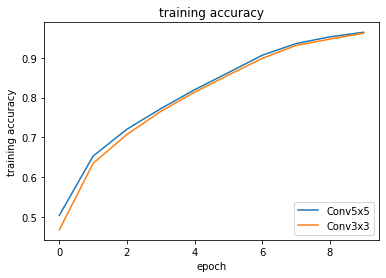

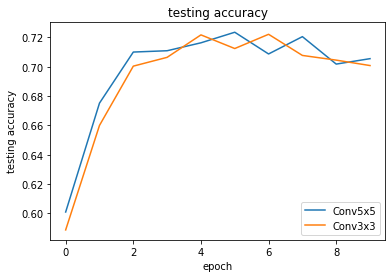

In [ ]:
plt.plot(all_train_accuracies)
plt.plot(all_train_accuracies_2)
plt.title('training accuracy')
plt.ylabel('training accuracy')
plt.xlabel('epoch')
plt.legend(['Conv5x5','Conv3x3'], loc='lower right')
plt.show()

plt.plot(all_test_accuracies)
plt.plot(all_test_accuracies_2)
plt.title('testing accuracy')
plt.ylabel('testing accuracy')
plt.xlabel('epoch')
plt.legend(['Conv5x5','Conv3x3'], loc='lower right')
plt.show()


Explanation:<br>
* As we can see from the training and testing accuracy plots, we are getting almost similar accuracy levels when we replace one convolution layer with 5x5 filters with that of 2 convolution layers based on 3x3 filters.
* This is interesting that we are getting same accuracy level when we use 25 filter weights based parameters (as in one 5x5 filter) compared to 18 parameters (as 9+9 in two 3x3 filters). So, this suggests that deeper network with fewer parameters can actually perform similar or even better compared to shallower network with more filter parameters. This is because deeper network makes more expressive model and at the same time small filters reduces overfitting and is good at generalization.
* So, therefore we usually prefer stack of small filters over a single large filter to improve the accuracy of our CNN model.